In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
#                 'log_scale' : np.log(.1),
                'log_both': np.log(0.6475) + np.log(252 * 1.564e-5),
               'rho': .5,
              }
else:
#     Daily
     true_params ={'log_both': 0.8819415995231439,
                   'log_scale': 1.7813838683227812,
                   'rho': 0.5294015291756116,
                   'phi': -0.29799406819991614,
#                    'pi': 0.05812774870906164,
                    'pi': 0, 
                   'theta': 0.43003184804533173}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2000
sim_dim = 1000
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
def compute_moments(log_both, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_both) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_both - log_scale)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_both=log_both, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [8]:
compute_moments(**true_params)

{'return_mean': 0.007673354139615026,
 'return_var': 0.005024656065865211,
 'vol_mean': 0.005103957600000001,
 'vol_var': 4.023225201945602e-05}

In [9]:
vl.compute_gamma(**true_params)

0.012227592917921712

In [10]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

In [11]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5}

In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [13]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [14]:
data.corr()

,vol,rtn
vol,1.0000,-0.1724
rtn,-0.1724,1.0000


In [15]:
data.head()

,vol,rtn
2000-01-01,0.001096,-0.016903
2000-01-02,0.009519,-0.056592
2000-01-03,0.015570,0.041266
2000-01-04,0.009664,-0.010822
2000-01-05,0.005958,0.125939


In [16]:
data.vol.var()

3.979507078312474e-05

In [17]:
init_constants = vl.compute_init_constants(data.vol)

In [18]:
init_constants

{'log_both': -5.962531957862049,
 'log_scale': -5.545561236776412,
 'rho': 0.49751483994993795}

In [19]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_both': -5.930093762072336,
  'log_scale': -5.564148484475202,
  'rho': 0.4711173182886512},
            log_both  log_scale       rho
 log_both   0.002707   0.001191 -0.000949
 log_scale  0.001191   0.001780 -0.000396
 rho       -0.000949  -0.000396  0.000785)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
omega

{'gamma': 0.011749396381883295,
 'beta': 2.6351112436221795,
 'psi': -3.334032506427887,
 'zeta': 0.7854170293681394,
 'log_both': -5.930093762072336,
 'log_scale': -5.564148484475202,
 'rho': 0.4711173182886512}

In [22]:
omega_cov

,beta,gamma,log_both,log_scale,psi,rho,zeta
beta,0.009520,-2.525968e-05,0.000000,0.000000,-0.004588,0.000000,0.000000
gamma,-0.000025,1.833311e-07,0.000000,0.000000,-0.000011,0.000000,0.000000
log_both,0.000000,0.000000e+00,0.002707,0.001191,0.000000,-0.000949,0.000000
log_scale,0.000000,0.000000e+00,0.001191,0.001780,0.000000,-0.000396,0.000000
psi,-0.004588,-1.053697e-05,0.000000,0.000000,0.083479,0.000000,0.000000
rho,0.000000,0.000000e+00,-0.000949,-0.000396,0.000000,0.000785,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000616


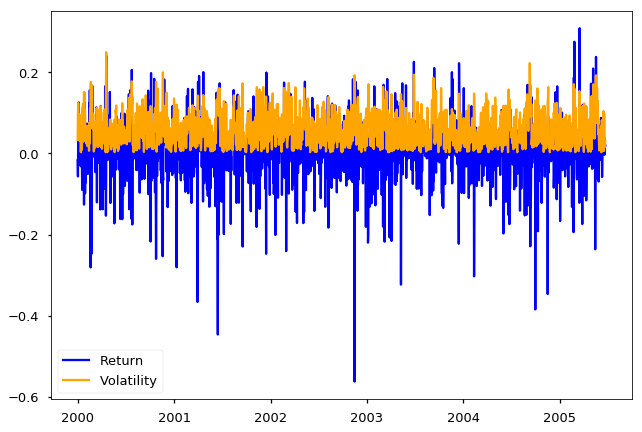

In [23]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [24]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.001550,-0.000477
rtn,-0.000477,0.004765


In [25]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

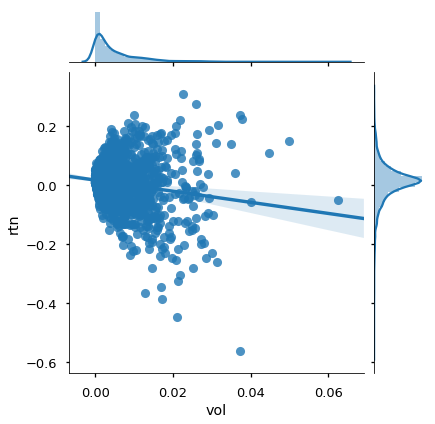

In [26]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [27]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.005119,0.008158
std,0.006308,0.069028
min,0.000010,-0.562791
25%,0.000804,-0.016739
50%,0.002776,0.013466
75%,0.007119,0.038941
max,0.062462,0.309205


## I now estimate all of the parameters

In [28]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [29]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [30]:
vol_estimator(data_arr[2])

({'log_both': -6.0113714353932,
  'log_scale': -5.499673641478174,
  'rho': 0.49145490052216306},
            log_both  log_scale       rho
 log_both   0.003188   0.001546 -0.001111
 log_scale  0.001546   0.003431 -0.000268
 rho       -0.001111  -0.000268  0.000919)

In [31]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [32]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'rho']]

In [33]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

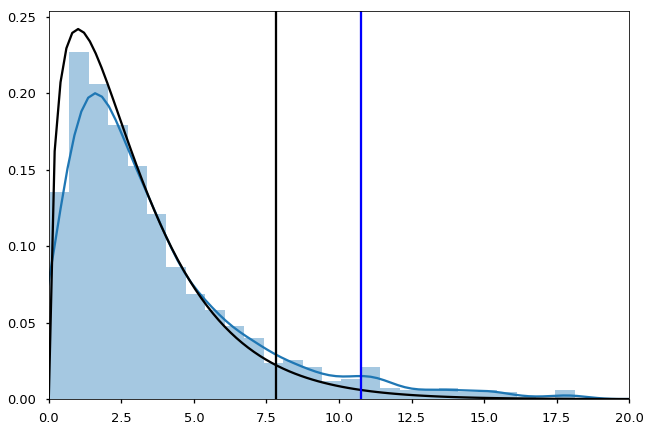

In [34]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [35]:
100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

10.2

In [36]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['rho', 'log_scale', 'log_both']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [37]:
vl.compute_init_constants(data.vol)

{'log_both': -5.962531957862049,
 'log_scale': -5.545561236776412,
 'rho': 0.49751483994993795}

In [38]:
true_params['log_both']

-5.97088622074413

In [39]:
np.amin([est[0]['log_both'] for est in est_arr])

-6.178451901839947

In [40]:
t_stats_df.describe()

,log_both,log_scale,rho
count,1000.000000,1000.000000,1000.000000
mean,0.005395,-0.453038,-0.213468
std,1.020938,1.065197,1.073536
min,-2.805281,-3.849397,-4.384207
25%,-0.696422,-1.148770,-0.883713
50%,-0.067160,-0.445066,-0.196721
75%,0.691066,0.294684,0.496810
max,3.728025,3.040139,3.046290


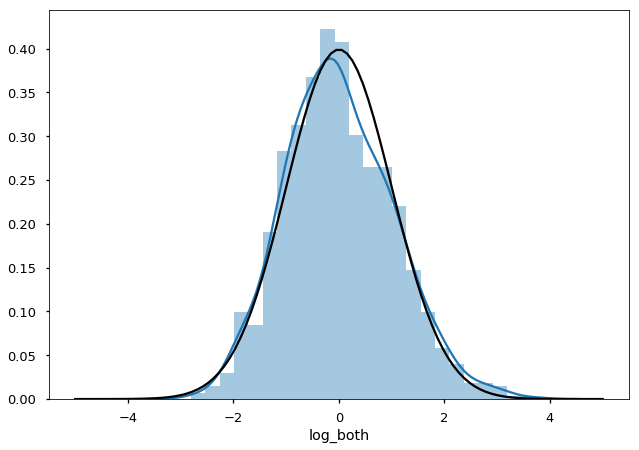

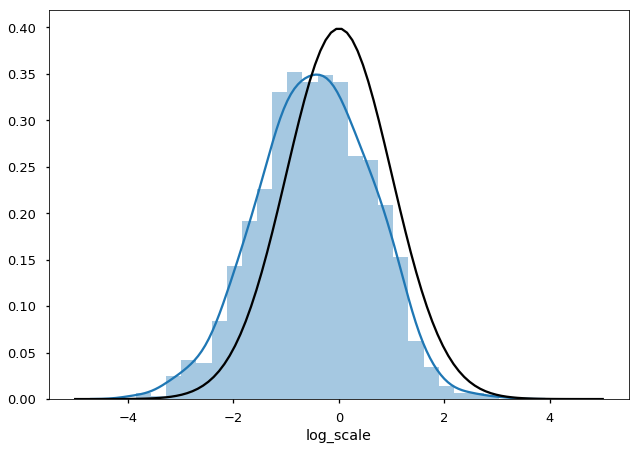

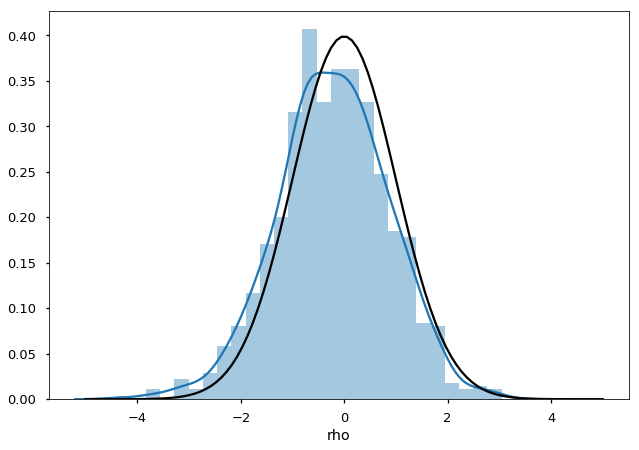

In [41]:
for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [42]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [43]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [44]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [45]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

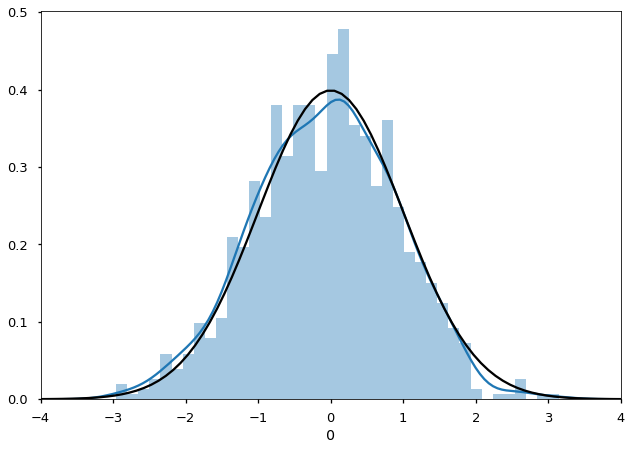

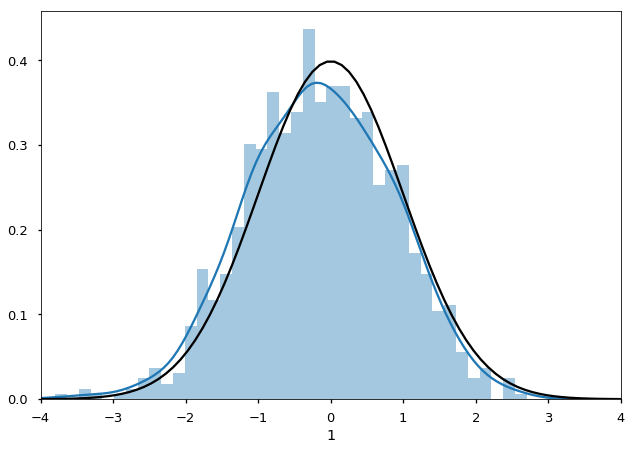

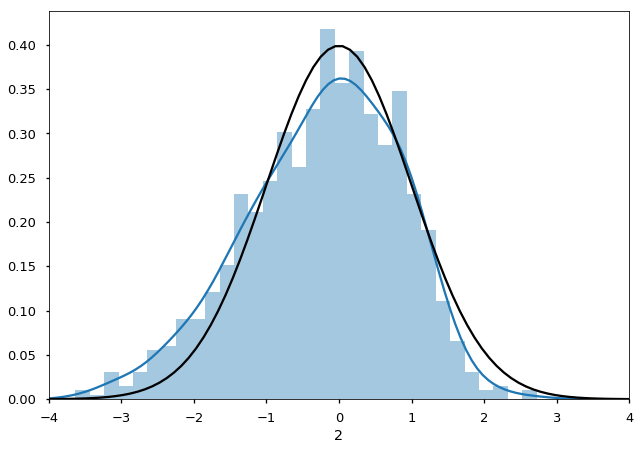

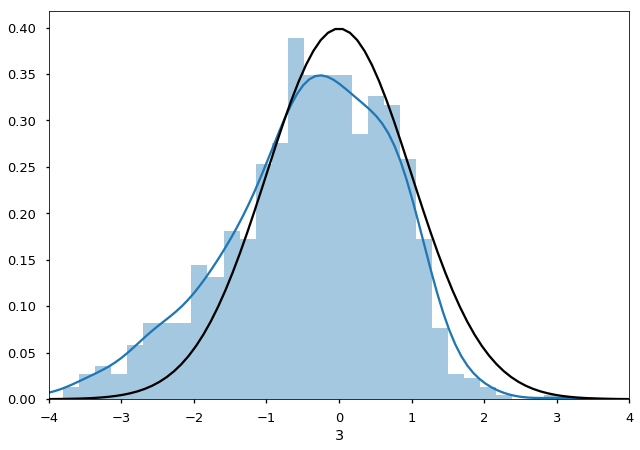

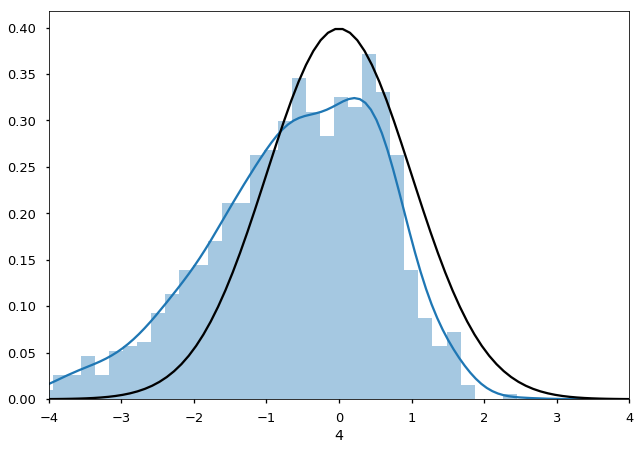

In [46]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

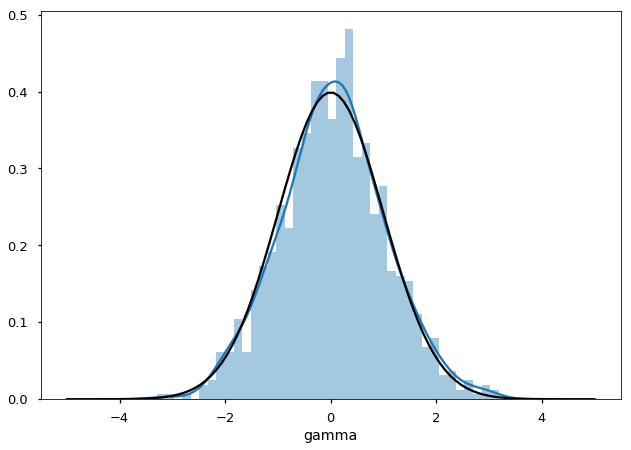

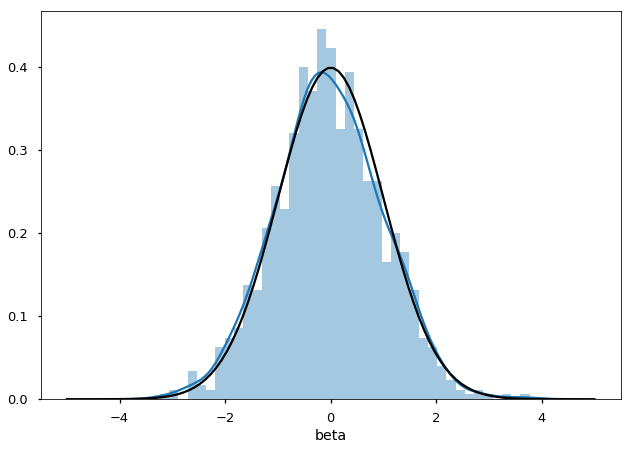

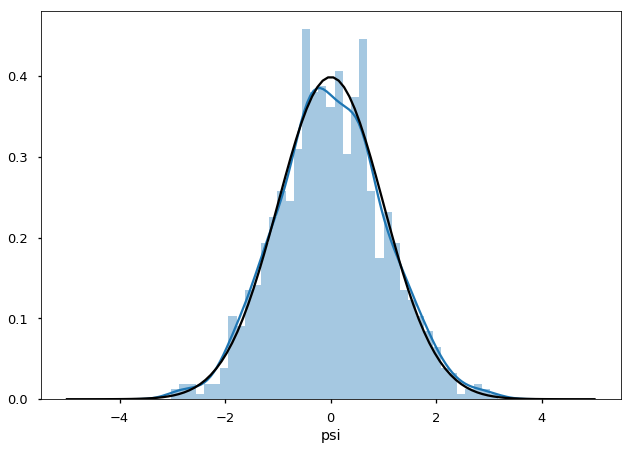

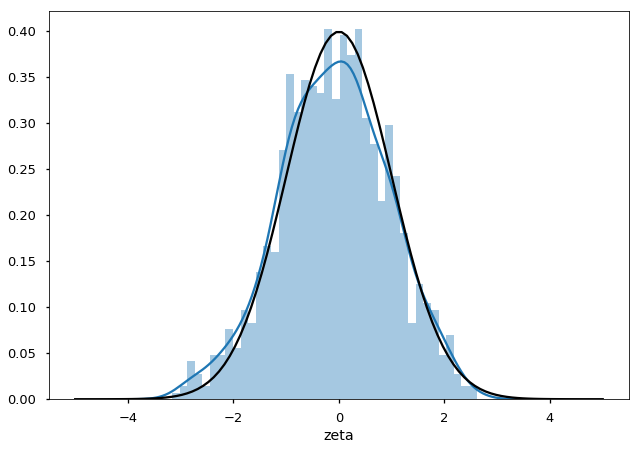

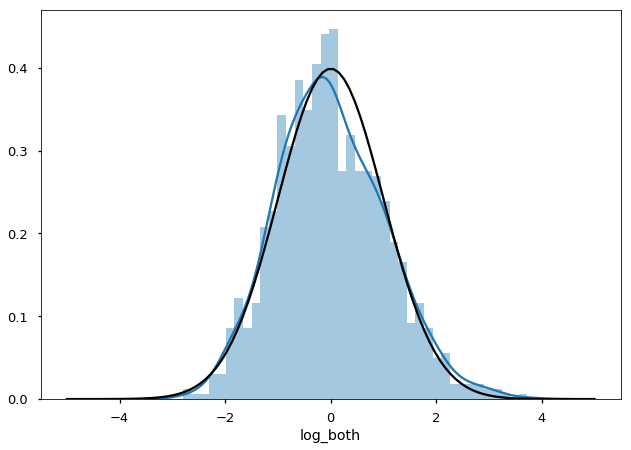

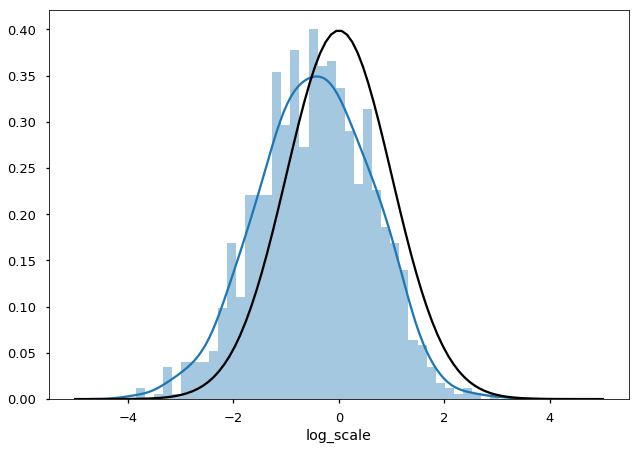

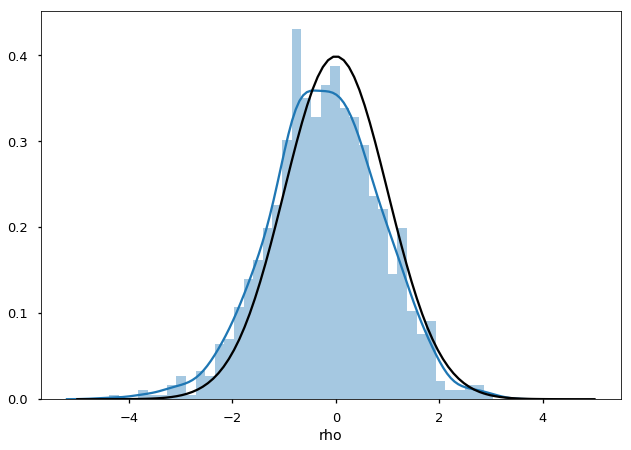

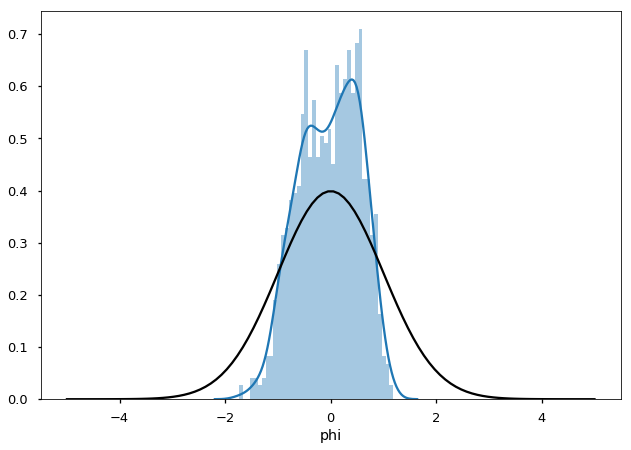

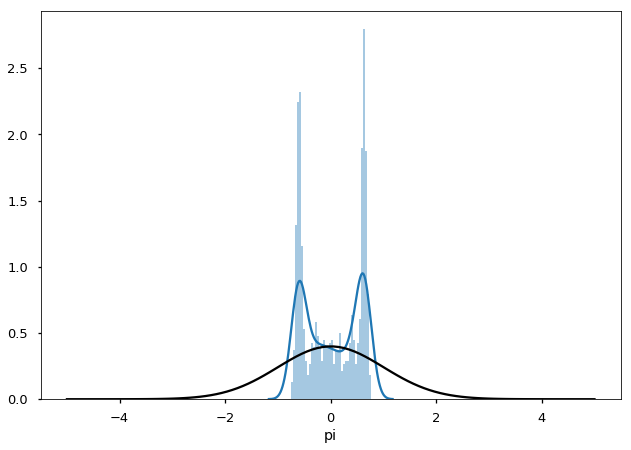

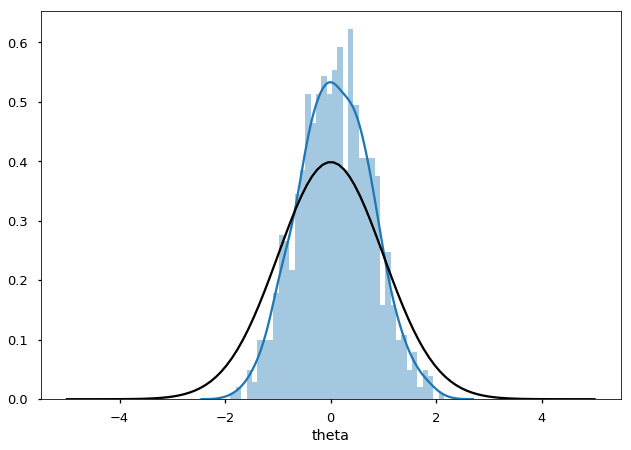

In [47]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

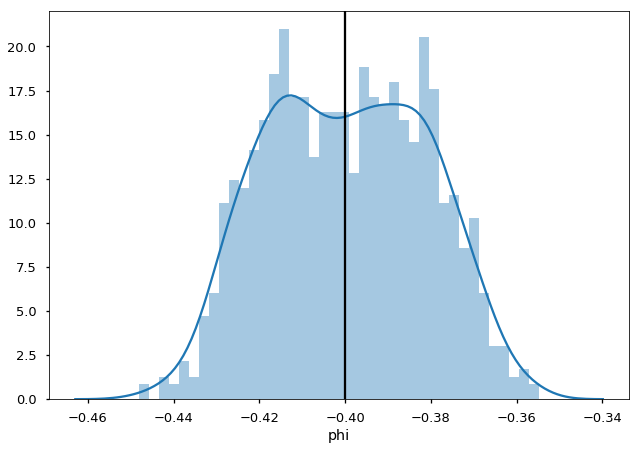

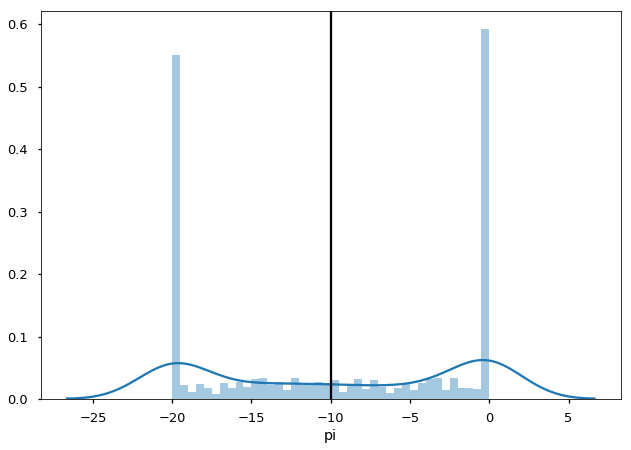

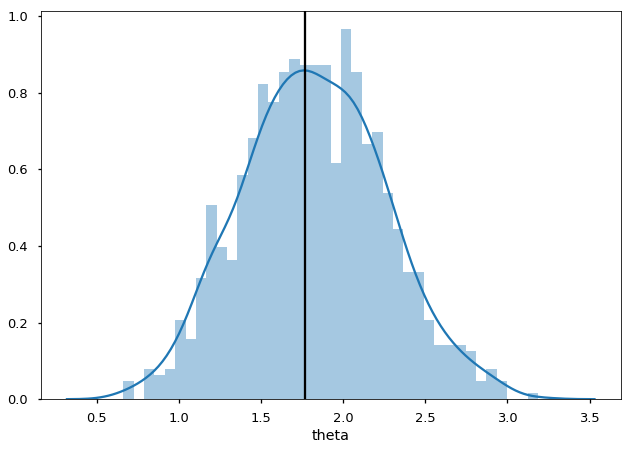

In [48]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [49]:
omega


{'gamma': 0.011749396381883295,
 'beta': 2.6351112436221795,
 'psi': -3.334032506427887,
 'zeta': 0.7854170293681394,
 'log_both': -5.930093762072336,
 'log_scale': -5.564148484475202,
 'rho': 0.4711173182886512}

In [50]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5}

In [51]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [52]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [53]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

array([-0.371,  0.001, -0.156,  0.013])

In [54]:
compute_ar(est_arr[0])

4.464593886704369

In [55]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

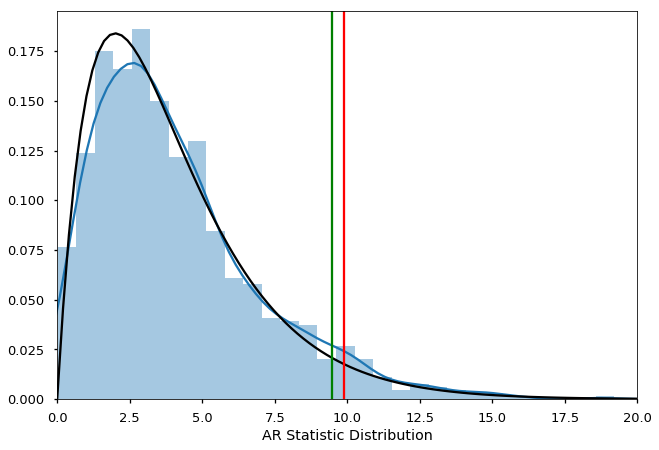

In [56]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [57]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [58]:
 stats.chi2.ppf(df=4, q=.95)

9.487729036781154

In [59]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

0    6.3
dtype: float64

In [60]:
# results[results <=0] = 0 

In [61]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [62]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [63]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [64]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [73]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,2.438997,7.071604,False,False
1,4.343854,6.996988,False,False
2,0.309956,7.021209,False,False
3,1.417509,7.087140,False,False
4,4.099116,6.996976,False,False


In [74]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,2.438997,7.071604,False,False
1,4.343854,6.996988,False,False
2,0.309956,7.021209,False,False
3,1.417509,7.087140,False,False
4,4.099116,6.996976,False,False


In [75]:
returnval.mean()

qlr_stat               2.693652
robust_qlr_qauntile    6.688591
robust                 0.053000
standard               0.033000
dtype: float64

In [76]:
true_params['phi']

-0.4

In [77]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [78]:
returnval.mean()

qlr_stat               2.693652
robust_qlr_qauntile    6.688591
robust                 0.053000
standard               0.033000
dtype: float64

In [79]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               2.693652
robust_qlr_qauntile    6.688591
robust                 0.053000
standard               0.033000
dtype: float64

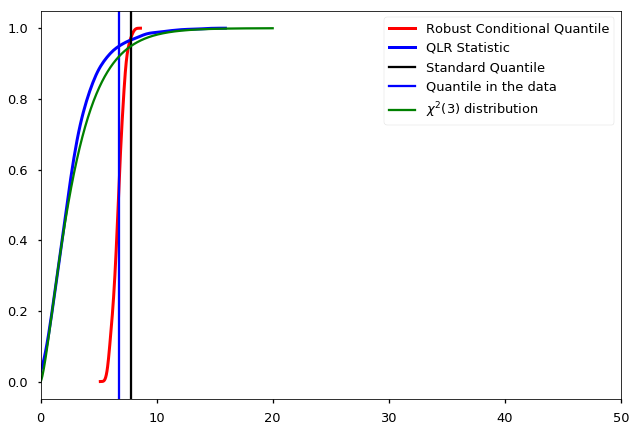

In [80]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)